In [10]:
import cv2
from matplotlib import pyplot as plt
import os

import numpy as np

In [11]:
path_imgs = "imgs"
path_labels = "imgs/labels"

clean_img_name = "1660021200.jpg"

# Get all the names of the images
imgs = os.listdir(path_imgs) # List of all the images in the folder

labels = os.listdir(path_labels) # List of all the labels in the folder

# Sort the lists
imgs.sort()
labels.sort()

if ".DS_Store" in imgs:
    imgs.pop(imgs.index(".DS_Store"))

if ".DS_Store" in labels:
    labels.pop(labels.index(".DS_Store"))

# Read the labels
imgs_with_labels = {}
for label_name in labels:
    with open(path_labels + "/" + label_name, "r") as f:
        img_name = label_name[:-4] + ".jpg"
        imgs_with_labels[img_name] = []
        for line in f:
            line = line.strip().split(",")
            label_name = line[0]
            label_x = line[1]
            label_y = line[2]
            img_name = line[3]

            if img_name not in imgs:
                continue

            label = {
                "label_name": label_name,
                "label_x": int(label_x),
                "label_y": int(label_y)
            }

            if img_name in imgs_with_labels:
                imgs_with_labels[img_name].append(label)

---
In this case, we will define the functions we need for the different tests.

We will define the absolute difference between two images.
Remove the part of the image that we don't want to analyse because it is the background.

In [12]:
def calculate_image_difference(path_imgs, img_name, clean_img_name):
    """
    Calculates the absolute difference between a grayscale image and its clean version.

    Parameters:
    - path_imgs (str): Path to the directory containing the images.
    - img_name (str): Name of the original image file.
    - clean_img_name (str): Name of the clean image file.

    Returns:
    - diff (numpy.ndarray): The absolute difference between the two images in grayscale.
    """
    # Load the original image and convert it to grayscale
    img = cv2.imread(os.path.join(path_imgs, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the clean image and convert it to grayscale
    clean_img = cv2.imread(os.path.join(path_imgs, clean_img_name))
    clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2GRAY)

    # Calculate the absolute difference
    diff = cv2.absdiff(img, clean_img)

    return diff

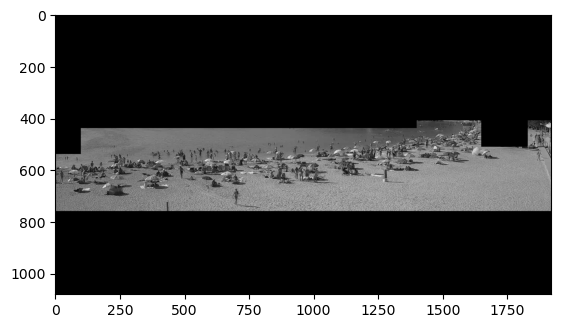

In [13]:
def remove_background(img, pixel = 0):
    """
    Removes specific regions of an image to create a new version without the background.

    Parameters:
    - img (numpy.ndarray): The input image, which must be in grayscale format.
    - pixel (int, optional): The pixel value used to "mask" the removed background areas. Default is 0 (black).

    Returns:
    - new_img (numpy.ndarray): A copy of the input image with the specified regions set to the `pixel` value.
    
    Notes:
    - This function is designed for grayscale images (`img` must already be converted to grayscale before calling).
    - The `pixel` parameter allows flexibility, letting the user specify a custom value for the masked areas, e.g., 0 for black or 255 for white.
    """
    new_img = img.copy()

    new_img[:440, :1400] = pixel
    new_img[:410, 1400:] = pixel
    new_img[760:, :] = pixel

    new_img[:540, :100] = pixel
    new_img[:512 , 1650:1830] = pixel

    return new_img

test = cv2.imread(os.path.join(path_imgs, img_name))
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)

mask = remove_background(test)

plt.imshow(mask, cmap='gray')

In [14]:
def find_contours(img, min_area=10, max_area=100):
    """
    Finds and filters contours in a grayscale image based on their area.
    Divides the image into three vertical sections and adjusts the coordinates 
    of contours from the second and third sections to match their original position.

    Parameters:
    - img (numpy.ndarray): Grayscale image where contours will be detected.
    - min_area (int, optional): Minimum area of the contours to be considered valid (default is 10).
    - max_area (int, optional): Maximum area of the contours to be considered valid (default is 100).

    Returns:
    - filtered_contours (list): A list of filtered contours, where each contour is a numpy array of points.
      Only contours with an area in the specified ranges are included.
    """
    
    # Create a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # img = cv2.dilate(img, kernel, iterations=1)

    # Apply dilation followed by erosion (morphological closing)
    morph_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    morph_img = img


    # # Visualize the morphological result
    # plt.imshow(morph_img, cmap='gray')
    # plt.show()
    x1 = 580

    x2 = 650

    contours, _ = cv2.findContours(morph_img[:x1][:], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]

    contours, _ = cv2.findContours(morph_img[x1:x2][:], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        for point in cnt:
            point[0][1] += x1


    filtered_contours_aux = [cnt for cnt in contours if min_area*15 <= cv2.contourArea(cnt) <= max_area]

    filtered_contours.extend(filtered_contours_aux)


    contours, _ = cv2.findContours(morph_img[x2:][:], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        for point in cnt:
            point[0][1] += x2
    
    filtered_contours_aux = [cnt for cnt in contours if min_area*30 <= cv2.contourArea(cnt) <= max_area]

    filtered_contours.extend(filtered_contours_aux)
    return filtered_contours



The other functions we will be using in this test are standard on the CV2, so we will set the functions for counting and detecting contours.

In [15]:
def count_contours(contours, area_threshold=10):
    """
    Counts the number of contours with an area above a given threshold and
    calculates the center of mass (centroid) for each contour. It also creates 
    a label for each detected contour.

    Parameters:
    - contours (list): List of contours detected in an image.
    - img (numpy.ndarray): The original image where the contours are drawn.
    - area_threshold (int, optional): Minimum area for a contour to be considered valid (default is 10).

    Returns:
    - predicted_labels (list): A list of dictionaries, each containing the label "Person" and the coordinates
      (x, y) of the centroid of the contour.
    - people_count (int): The total number of valid contours (i.e., contours with an area above the threshold).
    """
    predicted_labels = []
    people_count = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)

        if area > area_threshold:
            people_count += 1

        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        label = {
            "label_name": "Person",
            "label_x": cX,
            "label_y": cY
        }
        predicted_labels.append(label)
    
    return predicted_labels, people_count

In [16]:
from scipy.spatial import KDTree

def get_near_points_kdtree(predicted_labels, img_name, threshold=5):
    near_points = []

    labels = imgs_with_labels[img_name]

    # Crear la estructura KDTree con las predicciones
    predicted_coords = np.array([[p["label_x"], p["label_y"]] for p in predicted_labels])
    tree = KDTree(predicted_coords)

    # Controlar los índices ya usados
    used_indices = set()

    # Iterar sobre las etiquetas
    for label in labels:
        label_coord = [label["label_x"], label["label_y"]]

        # Encuentra la predicción más cercana
        distance, index = tree.query(label_coord)

        if distance <= threshold and index not in used_indices:
            near_points.append(predicted_labels[index])
            used_indices.add(index)

    return near_points

Now, we are ready to test the functions and analyse the results.

1660028400.jpg, Precision: 0.27, Recall: 0.39, F1: 0.32, Acc: 0.19, MSE: 133.29
1660032000.jpg, Precision: 0.29, Recall: 0.31, F1: 0.30, Acc: 0.18, MSE: 140.71
1660035600.jpg, Precision: 0.31, Recall: 0.41, F1: 0.36, Acc: 0.22, MSE: 154.12
1660039200.jpg, Precision: 0.37, Recall: 0.43, F1: 0.40, Acc: 0.25, MSE: 137.17
1660042800.jpg, Precision: 0.39, Recall: 0.44, F1: 0.41, Acc: 0.26, MSE: 123.14
1660046400.jpg, Precision: 0.36, Recall: 0.52, F1: 0.43, Acc: 0.27, MSE: 128.09
1660050000.jpg, Precision: 0.37, Recall: 0.52, F1: 0.43, Acc: 0.28, MSE: 94.13
1660057200.jpg, Precision: 0.35, Recall: 0.50, F1: 0.41, Acc: 0.26, MSE: 107.15
1660060800.jpg, Precision: 0.50, Recall: 0.60, F1: 0.55, Acc: 0.38, MSE: 103.18


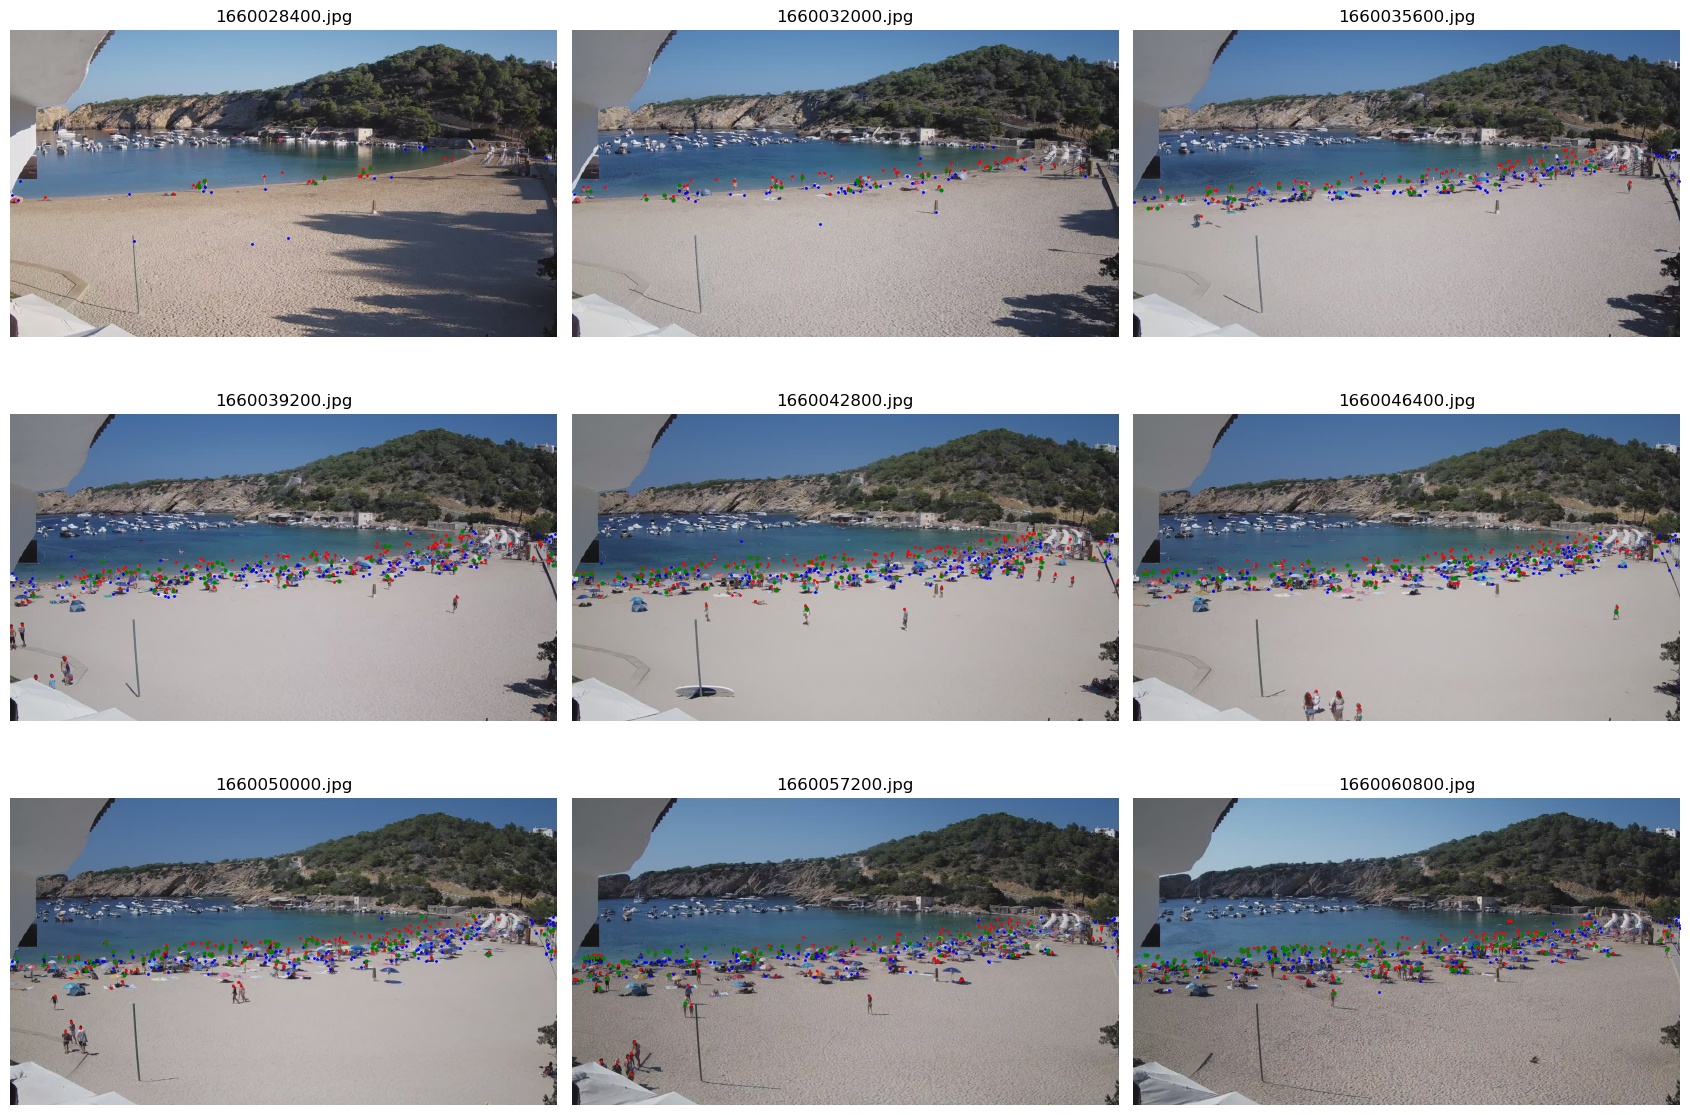

In [ ]:
from metrics import calculate_metrics

rows, cols = 3, 3

# Create a figure and a set of subplots
fig, axes = plt.subplots(rows, cols, figsize=(17, 12))
axes = axes.flatten()

# Itering over the images
idx = 0
for img_name, img_labels in imgs_with_labels.items():
    if img_name not in imgs:
        continue

    if img_name == "1660021200.jpg":
        continue

    diff = calculate_image_difference(path_imgs, img_name, clean_img_name)

    # diff = cv2.absdiff(img, clean_img)
    img_without_background = remove_background(diff, 64)

    # Apply GaussianBlur
    img_blur = cv2.GaussianBlur(img_without_background, (5, 5), 0)

    # Apply the detector of edges Canny
    edges = cv2.Canny(img_blur, 80, 200)

    # Find the contours
    contours = find_contours(edges, min_area=1, max_area=150)
    
    # Count the countours
    predicted_labels, people_count = count_contours(contours, area_threshold=20)

    # Read the img that we want to plot
    img = cv2.cvtColor(cv2.imread(os.path.join(path_imgs, img_name)), cv2.COLOR_BGR2RGB)

    ax = axes[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{img_name}")
    ax.axis('off')
    
    # Draw the predicted_labels
    for label in predicted_labels:
        ax.scatter(int(label["label_x"]), int(label["label_y"]), s=1, c='blue')

    # Draw the img_labels
    for label in img_labels:
        ax.scatter(int(label["label_x"]), int(label["label_y"]), s=1, c='red')
    

    near_points = get_near_points_kdtree(predicted_labels, img_name, threshold=20)

    for point in near_points:
        ax.scatter(int(point["label_x"]), int(point["label_y"]), s=4, c='green')

    precision, recall, f1_score, accuracy, mse = calculate_metrics(predicted_labels, imgs_with_labels, img_name, threshold=20)

    print(f"{img_name}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1_score:.2f}, Acc: {accuracy:.2f}, MSE: {mse:.2f}")
    # print(f"Predicted: {len(predicted_labels)}, Real: {len(img_labels)}, Corrected: {len(near_points)}")
    # print(f"Accuracy of predicte with the Real: {(len(near_points) / len(img_labels)):.2f}")
    # print("")
    idx += 1
    if idx >= rows * cols:
        break

plt.tight_layout()
plt.show()